In [ ]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 103.6 MB/s eta 0:00:00


In [ ]:
!pip install Ipython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 72.4 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer
import os
import tarfile
from keras.callbacks import ModelCheckpoint

#Importing dataset

In [ ]:
# # Path to your tar file in Google Drive
# tar_path = "/content/drive/MyDrive/english_dataset"

# # Create a folder to extract into (inside Drive)
# extract_path = "/content/drive/MyDrive/english_dataset_extracted"
# os.makedirs(extract_path, exist_ok=True)

# # Open and extract the tar file
# with tarfile.open(tar_path, "r:*") as tar:
#     tar.extractall(path=extract_path)

# # Path where WAV files are typically stored in LJSpeech dataset
# wavs_path = os.path.join(extract_path, "LJSpeech-1.1", "wavs")
# print("Extracted WAVs path:", wavs_path)

Extracted WAVs path: /content/drive/MyDrive/english_dataset_extracted/LJSpeech-1.1/wavs


In [ ]:
wavs_path ="/content/drive/MyDrive/english_dataset_extracted/LJSpeech-1.1/wavs/"
metadata_path = "/content/drive/MyDrive/english_dataset_extracted/LJSpeech-1.1/metadata.csv"

In [ ]:
# Read metadata file and parse it
metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
metadata_df = metadata_df[["file_name", "normalized_transcription"]]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
metadata_df.head(3)

,file_name,normalized_transcription
0,LJ015-0040,"This borrowing continued, and on such a scale ..."
1,LJ050-0148,the increased information supplied by other ag...
2,LJ018-0266,was at length advanced to the comparative ease...


# Train Test Split

In [ ]:
split = int(len(metadata_df) * 0.90)
df_train = metadata_df[:split]
df_val = metadata_df[split:]

In [ ]:
print(f"Size of the training set: {len(df_train)}")
print(f"Size of the training set: {len(df_val)}")

Size of the training set: 11790
Size of the training set: 1310


# Preprocessing

In [ ]:
# The set of characters accepted in the transcription.
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
# Mapping characters to integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
# Mapping integers back to original characters
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', np.str_('a'), np.str_('b'), np.str_('c'), np.str_('d'), np.str_('e'), np.str_('f'), np.str_('g'), np.str_('h'), np.str_('i'), np.str_('j'), np.str_('k'), np.str_('l'), np.str_('m'), np.str_('n'), np.str_('o'), np.str_('p'), np.str_('q'), np.str_('r'), np.str_('s'), np.str_('t'), np.str_('u'), np.str_('v'), np.str_('w'), np.str_('x'), np.str_('y'), np.str_('z'), np.str_("'"), np.str_('?'), np.str_('!'), np.str_(' ')] (size =31)


In [ ]:
# An integer scalar Tensor. The window length in samples.
frame_length = 256
# An integer scalar Tensor. The number of samples to step.
frame_step = 160
# An integer scalar Tensor. The size of the FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 384


def encode_single_sample(wav_file, label):
    #  Process the Audio
    # 1. Read wav file
    file = tf.io.read_file(wavs_path + wav_file + ".wav")
    # 2. Decode the wav file
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    # 3. Change type to float
    audio = tf.cast(audio, tf.float32)
    # 4. Get the spectrogram
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    # 5. We only need the magnitude, which can be derived by applying tf.abs
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    # 6. normalisation
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)
    # Process the label
    # 7. Convert label to Lower case
    label = tf.strings.lower(label)
    # 8. Split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    # 9. Map the characters in label to numbers
    label = char_to_num(label)
    # 10. Return a dict as our model is expecting two inputs
    return spectrogram, label

# Creating Dataset object

In [ ]:
batch_size = 32
# Define the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_name"]), list(df_train["normalized_transcription"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["normalized_transcription"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Visualize the data

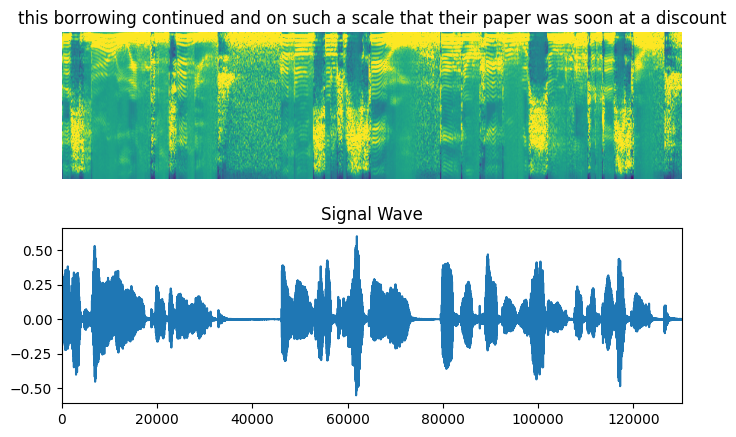

In [ ]:
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    # Wav
    file = tf.io.read_file(wavs_path + list(df_train["file_name"])[0] + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()

# Model

In [ ]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    """Model similar to DeepSpeech2."""
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")
    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    # Convolution layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5, name=f"dropout_rnn_{i}")(x)
    # Dense layer (renamed to avoid conflict)
    x = layers.Dense(units=rnn_units * 2, name="dense_fc")(x)  # Changed name
    x = layers.ReLU(name="dense_relu")(x)  # Changed name
    x = layers.Dropout(rate=0.5, name="dropout_fc")(x)  # Changed name
    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax", name="output")(x)
    # Model
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")
    # Optimizer
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    # Compile the model and return
    model.compile(optimizer=opt, loss=CTCLoss)
    return model


# # Get the model
# model = build_model(
#     input_dim=fft_length // 2 + 1,
#     output_dim=char_to_num.vocabulary_size(),
#     rnn_units=512,
# )
# model.summary(line_length=110)

# Training and Evaluating

In [ ]:
# Paths
save_dir = "/content/drive/MyDrive/saved_models/"
os.makedirs(save_dir, exist_ok=True)

keras_model_path = os.path.join(save_dir, "best_model.keras")  # Old .keras checkpoint

# Load the previous model if it exists, else build a new one
if os.path.exists(keras_model_path):
    print("Loading model from previous .keras checkpoint...")
    model = tf.keras.models.load_model(keras_model_path, custom_objects={"CTCLoss": CTCLoss})
else:
    print("No checkpoint found. Initializing new model.")
    model = build_model(  # Make sure you define this function elsewhere
        input_dim=fft_length // 2 + 1,
        output_dim=char_to_num.vocabulary_size(),
        rnn_units=512
    )

# Compile model (recompilation ensures optimizer is ready)
model.compile(optimizer='adam', loss=CTCLoss)
model.summary()

Loading model from previous .keras checkpoint...


Model: "DeepSpeech_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, None, 193)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ expand_dim (Reshape)            │ (None, None, 193, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, None, 97, 32)   │        14,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1_bn (BatchNormalization)  │ (None, None, 97, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1_relu (ReLU)              │ (None, None, 97, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, None, 49, 32)   │       236,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2_bn (BatchNormalization)  │ (None, None, 49, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2_relu (ReLU)              │ (None, None, 49, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, None, 1568)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, None, 1024)     │     6,395,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_rnn_1 (Dropout)         │ (None, None, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, None, 1024)     │     4,724,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_rnn_2 (Dropout)         │ (None, None, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, None, 1024)     │     4,724,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_rnn_3 (Dropout)         │ (None, None, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, None, 1024)     │     4,724,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_rnn_4 (Dropout)         │ (None, None, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, None, 1024)     │     4,724,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_fc (Dense)                │ (None, None, 1024)     │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_relu (ReLU)               │ (None, None, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_fc (Dropout)            │ (None, None, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, None, 32)       │        32,800 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,628,480 (101.58 MB)

 Trainable params: 26,628,352 (101.58 MB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)

In [ ]:
# Define the number of epochs
epochs = 5

# Callback function to check transcription on the val set
validation_callback = CallbackEval(validation_dataset)

# # Define the path to save the best model (Google Drive)
# save_dir = "/content/drive/MyDrive/saved_models/"  # Ensure this folder exists
# os.makedirs(save_dir, exist_ok=True)  # Create directory if it doesn't exist
model_checkpoint = ModelCheckpoint(
    filepath=keras_model_path,  # or .h5
    monitor="val_loss",  # Saves based on validation loss
    save_best_only=True,  # Only saves the best model
    mode="min",  # Minimize val_loss
    verbose=1,  # Prints a message when saving
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback, model_checkpoint],  # Added ModelCheckpoint
)

Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
1/1 ━━━━━━━━━━━━━━━━━

In [ ]:
# Load the original .keras model
model = tf.keras.models.load_model("/content/drive/MyDrive/saved_models/best_model.keras", custom_objects={"CTCLoss": CTCLoss})

model.export("/content/drive/MyDrive/saved_models/english_model_savedmodel")

Saved artifact at '/content/drive/MyDrive/saved_models/english_model_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, None, 193), dtype=tf.float32, name='input')
Output Type:
  TensorSpec(shape=(None, None, 32), dtype=tf.float32, name=None)
Captures:
  138555651337552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138555651337168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138555651335056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138555651340240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138555651338320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138555651339664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138555651336976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138555651334672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138555651340624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138555651333712: TensorSpec(shape=(), dtyp